In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
df = pd.read_csv('data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [31]:
df['kWh'] = df['Area_km2'] / df['Area / Electricity']
df = df.drop(['Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)

In [32]:
df = df.drop(['temp_spring_avg_lc', 'temp_summer_avg_lc', 'temp_fall_avg_lc', 'temp_winter_avg_lc', 
              'NDVI_spring_avg_lc', 'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc', 'NDVI_winter_avg_lc', 
              'npp_spring_avg_lc' , 'npp_summer_avg_lc' , 'npp_fall_avg_lc' , 'npp_winter_avg_lc'], axis=1)

In [33]:
df.columns

Index(['CO2 (mg C m¯² d¯¹)', 'CH4 (mg C m-2 d-1)', 'Area_km2', 'Age',
       'Volume_km3', 'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'NDVI_annual_avg', 'npp_annual_avg', 'erosion', 'precip', 'kWh'],
      dtype='object')

In [34]:
df.shape

(154, 13)

In [35]:
#df.rename(columns = {'CH4 (mg C m-2 d-1)':'CH4', 'CO2 (mg C m¯² d¯¹)':'CO2'}, inplace = True) 

In [36]:
#create co2 df

In [37]:
co2 = df.drop(['CH4 (mg C m-2 d-1)'], axis=1)
co2 = co2[co2['CO2 (mg C m¯² d¯¹)'].notna()]

In [38]:
#missingness

In [39]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(co2.shape[0])))
co2_imputed = model_impute.fit_transform(co2)

In [40]:
co2_imputed = pd.DataFrame(columns=co2.columns, data=co2_imputed)

In [41]:
#check
for column in co2_imputed:
    print(column, ':',  co2_imputed[column].isna().sum())

CO2 (mg C m¯² d¯¹) : 0
Area_km2 : 0
Age : 0
Volume_km3 : 0
Areakm2_div_Volkm3 : 0
org_c : 0
temp_annual_avg : 0
NDVI_annual_avg : 0
npp_annual_avg : 0
erosion : 0
precip : 0
kWh : 0


### Random Forest

In [42]:
X = co2_imputed.drop('CO2 (mg C m¯² d¯¹)', axis=1)
Y = co2_imputed['CO2 (mg C m¯² d¯¹)']

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [44]:
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(random_state=42, n_estimators=100, max_features=5)
randomForest.fit(x_train, y_train)
randomForest.score(x_train, y_train)

0.8996282108727958

In [45]:
print("The training error is: %.5f" % (1 - randomForest.score(x_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(x_test, y_test)))

The training error is: 0.10037
The test     error is: 0.78667


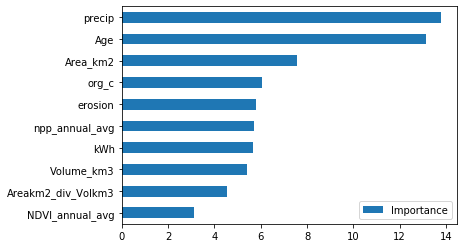

In [46]:
pd.DataFrame(index=x_train.columns, data=randomForest.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=True).head(10).plot(kind='barh')

#list(zip(x_train.columns, randomForest.feature_importances_*100))

#### grid search to find best parameters

In [47]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(200,500,50),
    "max_depth" : range(7,16),
    "max_features" : range(7,16)
}

grid_search_forest = GridSearchCV(randomForest, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_forest.fit(x_train, y_train)

CPU times: user 4.54 s, sys: 287 ms, total: 4.82 s
Wall time: 1min 16s


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=5,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,


In [48]:
grid_search_forest.best_params_

{'max_depth': 14, 'max_features': 11, 'n_estimators': 250}

In [49]:
grid_search_forest.best_score_

0.44443409301160974

In [50]:
#using the best parameters, what is the test score?

randomForest.set_params(max_depth =8, max_features = 9, n_estimators = 400)
randomForest.fit(x_train, y_train)
randomForest.score(x_test, y_test)

0.32179188795400293

In [51]:
estimators = pd.DataFrame(grid_search_forest.cv_results_)[['param_n_estimators','mean_test_score']]
depth = pd.DataFrame(grid_search_forest.cv_results_)[['param_max_depth','mean_test_score']]

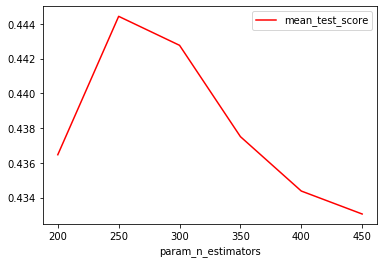

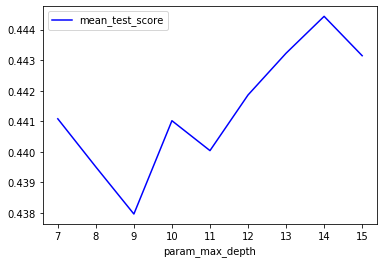

In [52]:
estimators.groupby('param_n_estimators').max().reset_index().plot(kind='line', x='param_n_estimators',y='mean_test_score', c='red')
depth.groupby('param_max_depth').max().reset_index().plot(kind='line', x='param_max_depth', y='mean_test_score', c='blue')


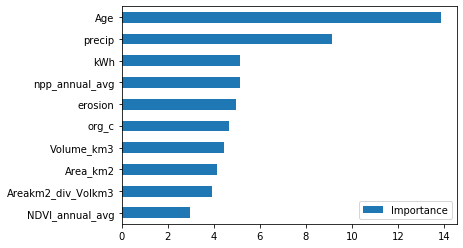

In [53]:
pd.DataFrame(index=x_train.columns, data=randomForest.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=True).head(10).plot(kind='barh')